In [1]:
from google.colab import drive
drive.mount('gdrive')

Mounted at gdrive


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.manifold import TSNE

%matplotlib inline

# Import modules to evaluate the metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc

In [5]:
glove_path ='/content/gdrive/MyDrive/moseas_french/multilingual_embeddings.fr'

data_path = "/content/gdrive/MyDrive/moseas_french/batch_1_2/processed_moseas_french_batch_1_2_avglabel.csv"
TEXT_COLUMN = "sentence"

# Load in GloVe

In [6]:
from gensim.scripts.glove2word2vec import glove2word2vec

word2vec_output_file = glove_path+'.word2vec'
glove2word2vec(glove_path, word2vec_output_file)

(40417, 300)

In [7]:
# testing: king+woman-man=queen
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

#Show a word embedding
# print('roi (king): ',model.get_vector('roi'))

result = model.most_similar(positive=['femme', 'roi'], negative=['homme'], topn=1)

print('Most similar word to roi + femme: ', result)

Most similar word to roi + femme:  [('reine', 0.6335461139678955)]


# vectorizer class

In [8]:

data = pd.read_csv(data_path,dtype={"sentence":str})
data.head()

,key,start,end,sentence,anger,confident,disgust,dominant,eloquent,entertaining,fear,gender,happiness,humorous,is_opinion,narcissist,nervous,passionate,persuasive,relaxed,reserved,sadness,sarcastic,surprise,sentiment,secret_word1,secret_word2,secret_word3
0,HfTLQqNNsnM_0,0.06,2.770000,bonjour je guillaume mais tu peux aussi monsie...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0.333333,{},{},{}
1,HfTLQqNNsnM_1,5.36,8.098571,cest la question que vous mavez posé voici la ...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.000000,sentiments,émotions,attributs
2,HfTLQqNNsnM_2,10.23,20.260000,dans cette vidéo je vais supposer que le garço...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.000000,sentiments,émotions,attributs
3,HfTLQqNNsnM_3,20.82,21.590000,ca peut être un peu partout,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.000000,banane,bureau,augmenter
4,HfTLQqNNsnM_4,23.86,26.440000,pour attirer son attention tu dois mettre en a...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0.000000,banane,bureau,augmenter


In [9]:
word_level_rep = {} # video_key: 1D list of glove embedding, the ith position ==> ith word glove embedding
all_sent_emb = dict() # word: (sentiment, glove_embedding)
for index,entry in data.iterrows():
  embs = []

  video_id = entry["key"]
  sentence = entry["sentence"]
  sentiment = entry["sentiment"]

  for word in sentence.split():
    try:
      embs.append(model.get_vector(word))
      word_level_rep[video_id] = embs
      if word not in all_sent_emb:
        all_sent_emb[word] = (sentiment, model.get_vector(word))
    except KeyError:
      pass # not adding anything for now

print(word_level_rep['2_Y5gZc_zug_0'])




[array([ 3.51509511e-01,  4.70678389e-01, -7.20044315e-01, -5.21377921e-01,
        1.68931872e-01,  5.78507602e-01,  6.05325222e-01, -1.01224196e+00,
       -5.04963338e-01,  8.07500720e-01, -1.05851218e-01, -5.01368605e-02,
        9.95821878e-02, -4.19032365e-01, -5.45541704e-01,  8.36151540e-01,
        1.04202777e-01,  7.16773808e-01, -1.41101554e-01,  7.30409205e-01,
       -3.79112482e-01,  1.27644334e-02,  2.10126322e-02, -3.30313534e-01,
       -1.47450015e-01, -3.40626724e-02, -3.10344487e-01, -5.27044944e-02,
        4.07215029e-01,  1.00311823e-01, -7.52762193e-03, -3.15494627e-01,
       -4.52271014e-01,  2.12407872e-01,  4.49859887e-01, -6.05248094e-01,
        2.77544230e-01,  2.78131664e-01,  1.13969818e-01,  7.15122819e-01,
        2.41257921e-01, -1.31647480e+00,  2.02433705e-01, -5.37599623e-01,
       -3.09619129e-01,  2.58909374e-01, -1.54374927e-01, -3.22854221e-01,
        5.69253445e-01, -2.84703493e-01, -1.39212444e-01,  3.11577171e-01,
        6.77484095e-01, 

In [11]:
emb_list = []
emb_index = []

for word in all_sent_emb:
  emb_list.append(all_sent_emb[word][1].reshape(300))
  emb_index.append(all_sent_emb[word][0])

tsne_matrix = np.matrix(emb_list)
print(tsne_matrix.shape)
# print(tsne_matrix)
tsne_model = TSNE(n_components=2)
low_dim_data = tsne_model.fit_transform(tsne_matrix)
print(low_dim_data.shape)


tsne_df = pd.DataFrame(low_dim_data, index=emb_index)
tsne_df.head(5)
print(tsne_df)


(7172, 300)
(7172, 2)
[[ 3.5150951e-01  4.7067839e-01 -7.2004431e-01 ...  6.4459956e-01
  -5.9530240e-01 -2.2468597e-01]
 [-6.6270615e-04  3.1234971e-01 -3.6816877e-01 ...  7.3712267e-02
   2.2839877e-01  2.8029794e-01]
 [-3.2364383e-01  3.4531739e-01 -3.4641784e-01 ... -3.7079880e-01
   2.5049868e-01  2.1511400e-01]
 ...
 [-2.7990341e-01 -1.2721184e-01 -2.9888615e-01 ... -5.6776624e-02
   2.8137979e-01 -1.2251362e-01]
 [ 2.9613149e-01  6.1942858e-01 -1.4436577e-01 ...  2.3534381e-01
   1.2954915e-01 -1.3179366e-01]
 [ 2.6192084e-01  2.4853313e-01  6.3735489e-03 ...  9.4765598e-01
  -5.3902161e-01  3.3050361e-01]]


In [15]:
tsne_df

,0,1
0.333333,-2.728112,13.903959
0.333333,-8.388556,5.033091
0.333333,-5.156427,3.826360
0.333333,-13.029567,0.967011
0.333333,-9.338046,5.469511
...,...,...
-1.666667,13.357894,-8.583877
-1.666667,8.889454,5.334549
-1.666667,1.691297,6.341274
-1.666667,14.028390,-5.071468


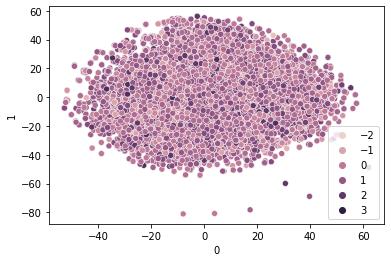

In [12]:
ax = sns.scatterplot(data=tsne_df, x=0, y=1, hue=tsne_df.index)

# pick a subset of 50 words from each sentiment category and plot the t-sne

In [13]:
emb_list = []
emb_index = []

for word in all_sent_emb:
  if emb_index.count(all_sent_emb[word][0]) < 50:
    emb_list.append(all_sent_emb[word][1].reshape(300))
    emb_index.append(all_sent_emb[word][0])
  

tsne_matrix = np.matrix(emb_list)
print(tsne_matrix.shape)
# print(tsne_matrix)
tsne_model = TSNE(n_components=2)
low_dim_data = tsne_model.fit_transform(tsne_matrix)
print(low_dim_data.shape)


tsne_df = pd.DataFrame(low_dim_data, index=emb_index)
print(list(tsne_df.index).count(-3))
print(tsne_matrix)

(667, 300)
(667, 2)
0
[[ 3.51509511e-01  4.70678389e-01 -7.20044315e-01 ...  6.44599557e-01
  -5.95302403e-01 -2.24685967e-01]
 [-6.62706152e-04  3.12349707e-01 -3.68168771e-01 ...  7.37122670e-02
   2.28398770e-01  2.80297935e-01]
 [-3.23643833e-01  3.45317394e-01 -3.46417844e-01 ... -3.70798796e-01
   2.50498682e-01  2.15113997e-01]
 ...
 [-6.09502077e-01  1.88017804e-02  8.96315202e-02 ...  2.19203562e-01
  -7.82001555e-01 -6.17238224e-01]
 [-1.02532484e-01 -7.59873092e-01 -5.90213537e-01 ...  4.50219870e-01
  -4.30357486e-01  1.02468334e-01]
 [-3.35095793e-01 -3.82845223e-01  2.89321363e-01 ... -5.63709676e-01
  -2.95456767e-01 -4.32412744e-01]]


Each sentiment category samples 50 words, except the -3 category with 32 words


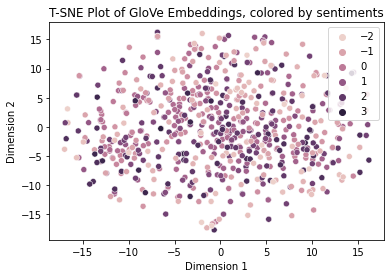

In [22]:
ax = sns.scatterplot(data=tsne_df, x=0, y=1, hue=tsne_df.index)
ax.set_title("T-SNE Plot of GloVe Embeddings, colored by sentiments")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
print("Each sentiment category samples 50 words, except the -3 category with 32 words")
plt.savefig("/content/gdrive/MyDrive/moseas_french/glove_avg_emb.png")

In [ ]:
# don't run
# https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne?scriptVersionId=1018109&cellId=7


def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

# Sentence Bert


In [ ]:
!pip install -U sentence-transformers

     |████████████████████████████████| 78 kB 6.0 MB/s 
     |████████████████████████████████| 2.9 MB 22.2 MB/s 
     |████████████████████████████████| 3.3 MB 43.8 MB/s 
     |████████████████████████████████| 1.2 MB 29.3 MB/s 
     |████████████████████████████████| 56 kB 4.8 MB/s 
     |████████████████████████████████| 895 kB 36.9 MB/s 
     |████████████████████████████████| 636 kB 51.3 MB/s 
     |████████████████████████████████| 109 kB 51.5 MB/s 
     |████████████████████████████████| 546 kB 67.7 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=afc959827057e26a63d79328306095e925b9523a599a7d3e8ea6939d17a74078
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from sentence_transformers import SentenceTransformer

pretrained_model = SentenceTransformer('all-mpnet-base-v2')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
import csv

embed_dict = {}
with open("/content/gdrive/MyDrive/moseas_french/batch_1_2/processed_moseas_french_batch_1_2.csv") as f:
    data = csv.DictReader(f)
    for i, row in enumerate(data):
        embed = pretrained_model.encode(row['sentence'])
        embed_dict[row['key']] = (embed, row['sentiment'], row['happiness'])


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
  warnings.warn("`max_length` is ignored when `padding`=`True`.")


In [ ]:
for val in embed_dict.values():
    print(val[0].shape)

In [ ]:
# SENTIMENT

emb_list = []
emb_index = []

for val in embed_dict.values():
  # if int(val[1]) != 0: 
  emb_list.append(val[0].reshape(768))
  emb_index.append(val[1])

tsne_matrix = np.matrix(emb_list)
print(tsne_matrix.shape)
# print(tsne_matrix)
tsne_model = TSNE(n_components=2)
low_dim_data = tsne_model.fit_transform(tsne_matrix)
print(low_dim_data.shape)


tsne_df = pd.DataFrame(low_dim_data, index=emb_index)
tsne_df.head(5)
print(tsne_matrix)

(4951, 768)
(4951, 2)
[[ 0.00831433  0.04949458  0.00138985 ...  0.03367279  0.01191525
  -0.03031262]
 [-0.01113822 -0.02977372  0.0074262  ...  0.06307293 -0.00388927
  -0.02656843]
 [ 0.00714174 -0.01408492  0.0472725  ...  0.01895     0.02472701
  -0.03954018]
 ...
 [-0.0164329  -0.01170123  0.02847948 ...  0.01125782  0.01291868
  -0.01988732]
 [-0.03562193  0.05937372  0.03040708 ...  0.02365574  0.01733812
   0.02332867]
 [-0.01938754  0.00881512  0.01845677 ...  0.04464449 -0.02198616
  -0.00303155]]


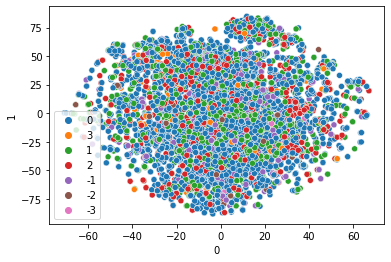

In [ ]:
ax = sns.scatterplot(data=tsne_df, x=0, y=1, hue=tsne_df.index)

# label distribution


In [ ]:
glove_path ='/content/gdrive/MyDrive/moseas_french/multilingual_embeddings.fr'

# data_path = "/content/gdrive/MyDrive/moseas_french/batch_1_2/processed_moseas_french_batch_1_2.csv"
data_path = "/content/gdrive/MyDrive/moseas_french/batch_1_2/processed_moseas_french_batch_1_2_avglabel.csv"
TEXT_COLUMN = "sentence"

In [ ]:
data = pd.read_csv(data_path,dtype={"sentence":str, "sentiment":float})
data.head()

,key,start,end,sentence,anger,confident,disgust,dominant,eloquent,entertaining,fear,gender,happiness,humorous,is_opinion,narcissist,nervous,passionate,persuasive,relaxed,reserved,sadness,sarcastic,surprise,sentiment,secret_word1,secret_word2,secret_word3
0,HfTLQqNNsnM_0,0.06,2.770000,bonjour je guillaume mais tu peux aussi monsie...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0.333333,{},{},{}
1,HfTLQqNNsnM_1,5.36,8.098571,cest la question que vous mavez posé voici la ...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.000000,sentiments,émotions,attributs
2,HfTLQqNNsnM_2,10.23,20.260000,dans cette vidéo je vais supposer que le garço...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.000000,sentiments,émotions,attributs
3,HfTLQqNNsnM_3,20.82,21.590000,ca peut être un peu partout,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.000000,banane,bureau,augmenter
4,HfTLQqNNsnM_4,23.86,26.440000,pour attirer son attention tu dois mettre en a...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0.000000,banane,bureau,augmenter


Text(0.5, 0, 'Sentiments')

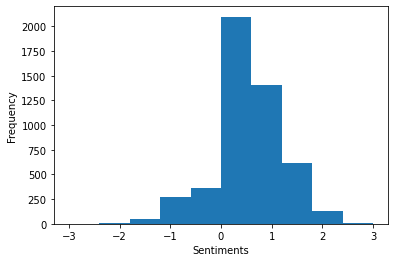

In [ ]:
plt.hist(data["sentiment"])
plt.ylabel("Frequency")
plt.xlabel("Sentiments")
# plt.title("Distribution of Sentiment Labels - Averaged")